# Midterm project 2

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv').drop(['customerID'],
                                                                axis=1)
data.dtypes
print(data.shape)

(7043, 20)


## Question 1

_Visualize the univariate distribution of each input variable and the target variable “churn”._

Notice that lots of variables are `object`, that is, non-numerical.

Recall that `TotalCharges` is a quantitive variable but is represented as `object`. We want to get rid of it:

In [3]:
def get_non_numbers(data):
    out = []
    for x in data:
        if not "." in x:  # if this does not look like a decimal number
            if not x.isnumeric():  # if this is not an integer at all
                out.append(x)
    return out


print(get_non_numbers(data['TotalCharges']))


def str2float(x: str):
    if '.' in x or x.isnumeric():
        return np.float32(x)
    else:
        return np.nan


data['TotalCharges'] = data['TotalCharges'].apply(str2float)

data = data.dropna(axis=0)

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


In [4]:
data.isna().values.any()

False

In [5]:
data.shape

(7032, 20)

Let us first consider the total count of `yes` vs. `no` for the `Churn` column

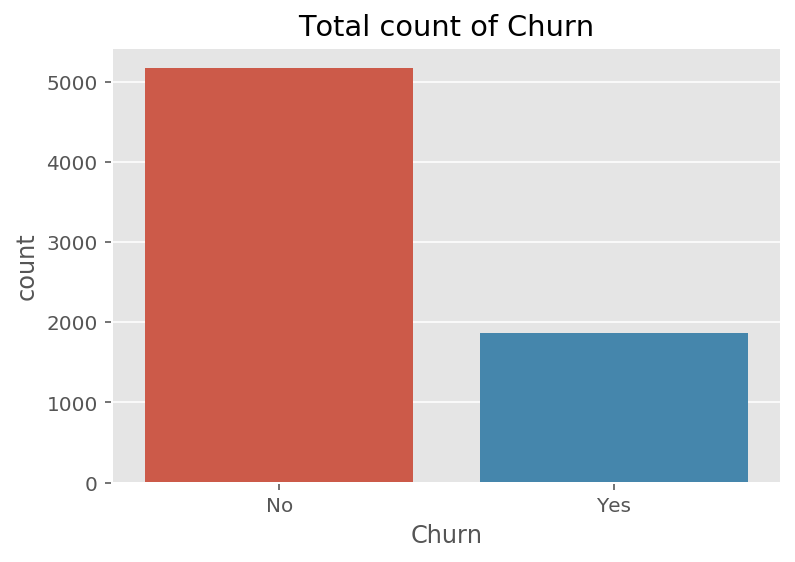

In [6]:
_ = sns.countplot(data=data, x='Churn')
_ = plt.title('Total count of Churn')

Next, let us look at every variable separately, colored by `Churn` value

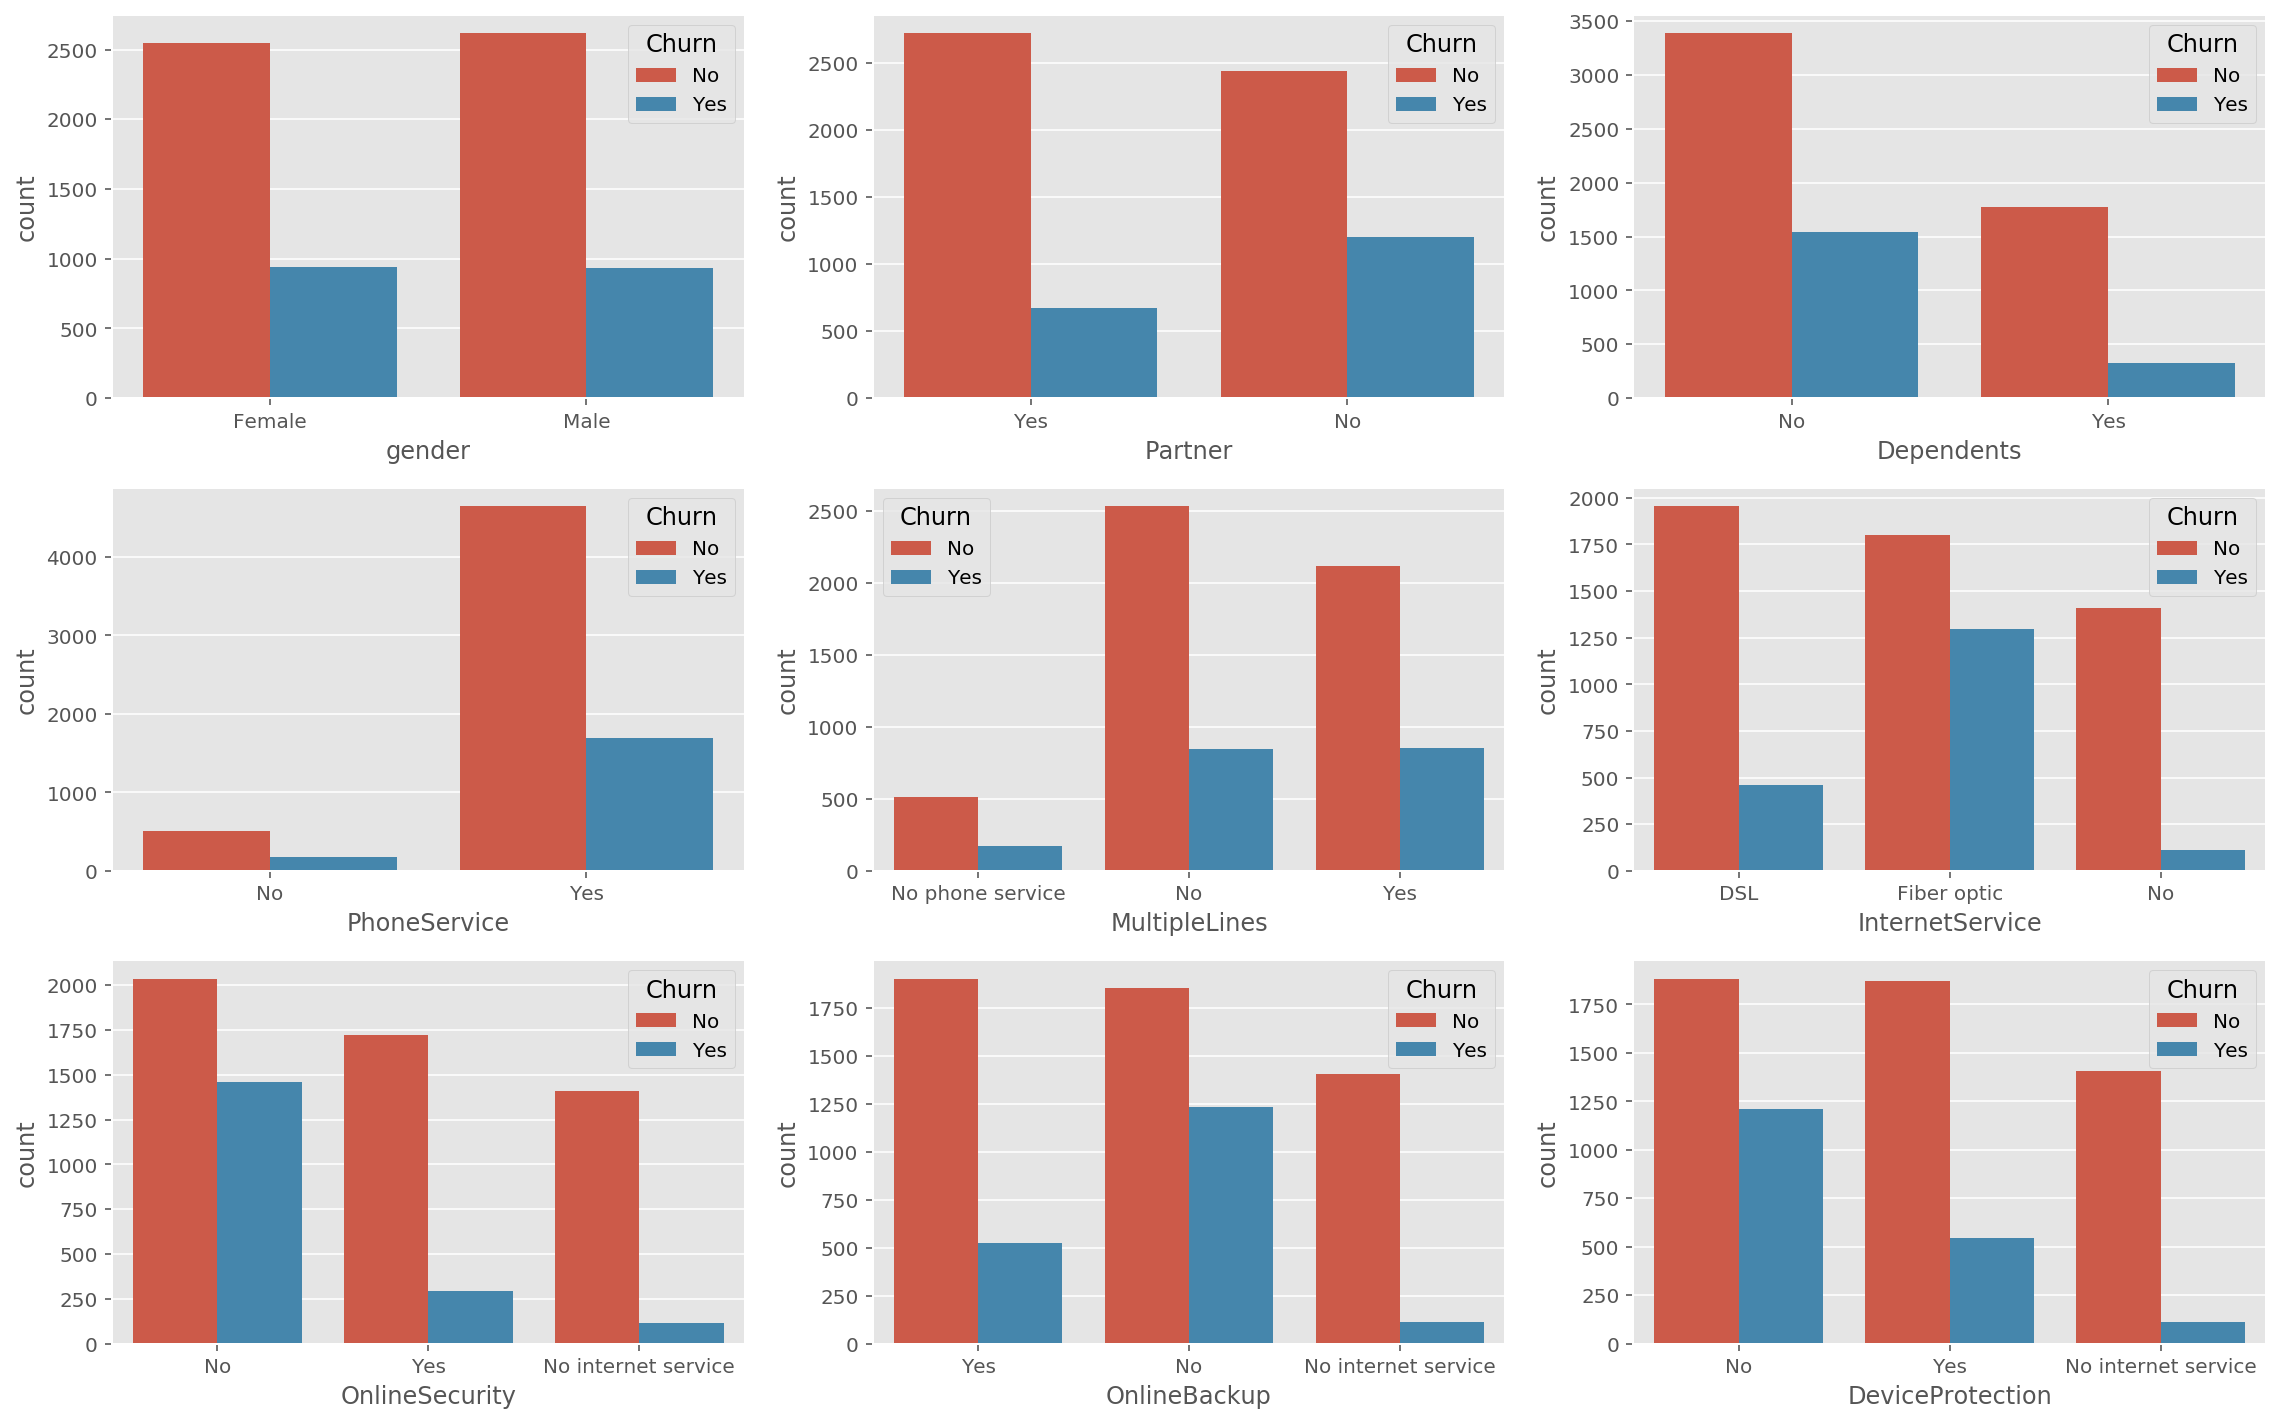

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))
k = 0
obj = data.select_dtypes(object).columns.tolist()[:-1]
for i in range(3):
    for j in range(3):
        _ = sns.countplot(data=data, x=obj[k], hue='Churn', ax=ax[i, j])
        k += 1

plt.tight_layout()

Some preliminary conclusions:

1) Male and female users are equally likely to say yes or no

2) If you have a partner, then you are more likely to churn than if you don't have a partner, and you are more likely to _not_ churn than when you don't

3) Those who have dependents are less likely to churn (that is, to say `Yes`)

4) Those who have phone service are more likely to churn

5) When it comes to multiple phone lines, it appears that those who do/don't are equally likely to say yes and those who don't are more likely to say no

6) In `InternetService`, fiber optic seems to drive most of the churn

7) Similarly, when one does not have online security they are more likely to churn.

8) Among people who don't use online backups, we see great spike in churning.

9) Those who don't have device protection are more likely to churn

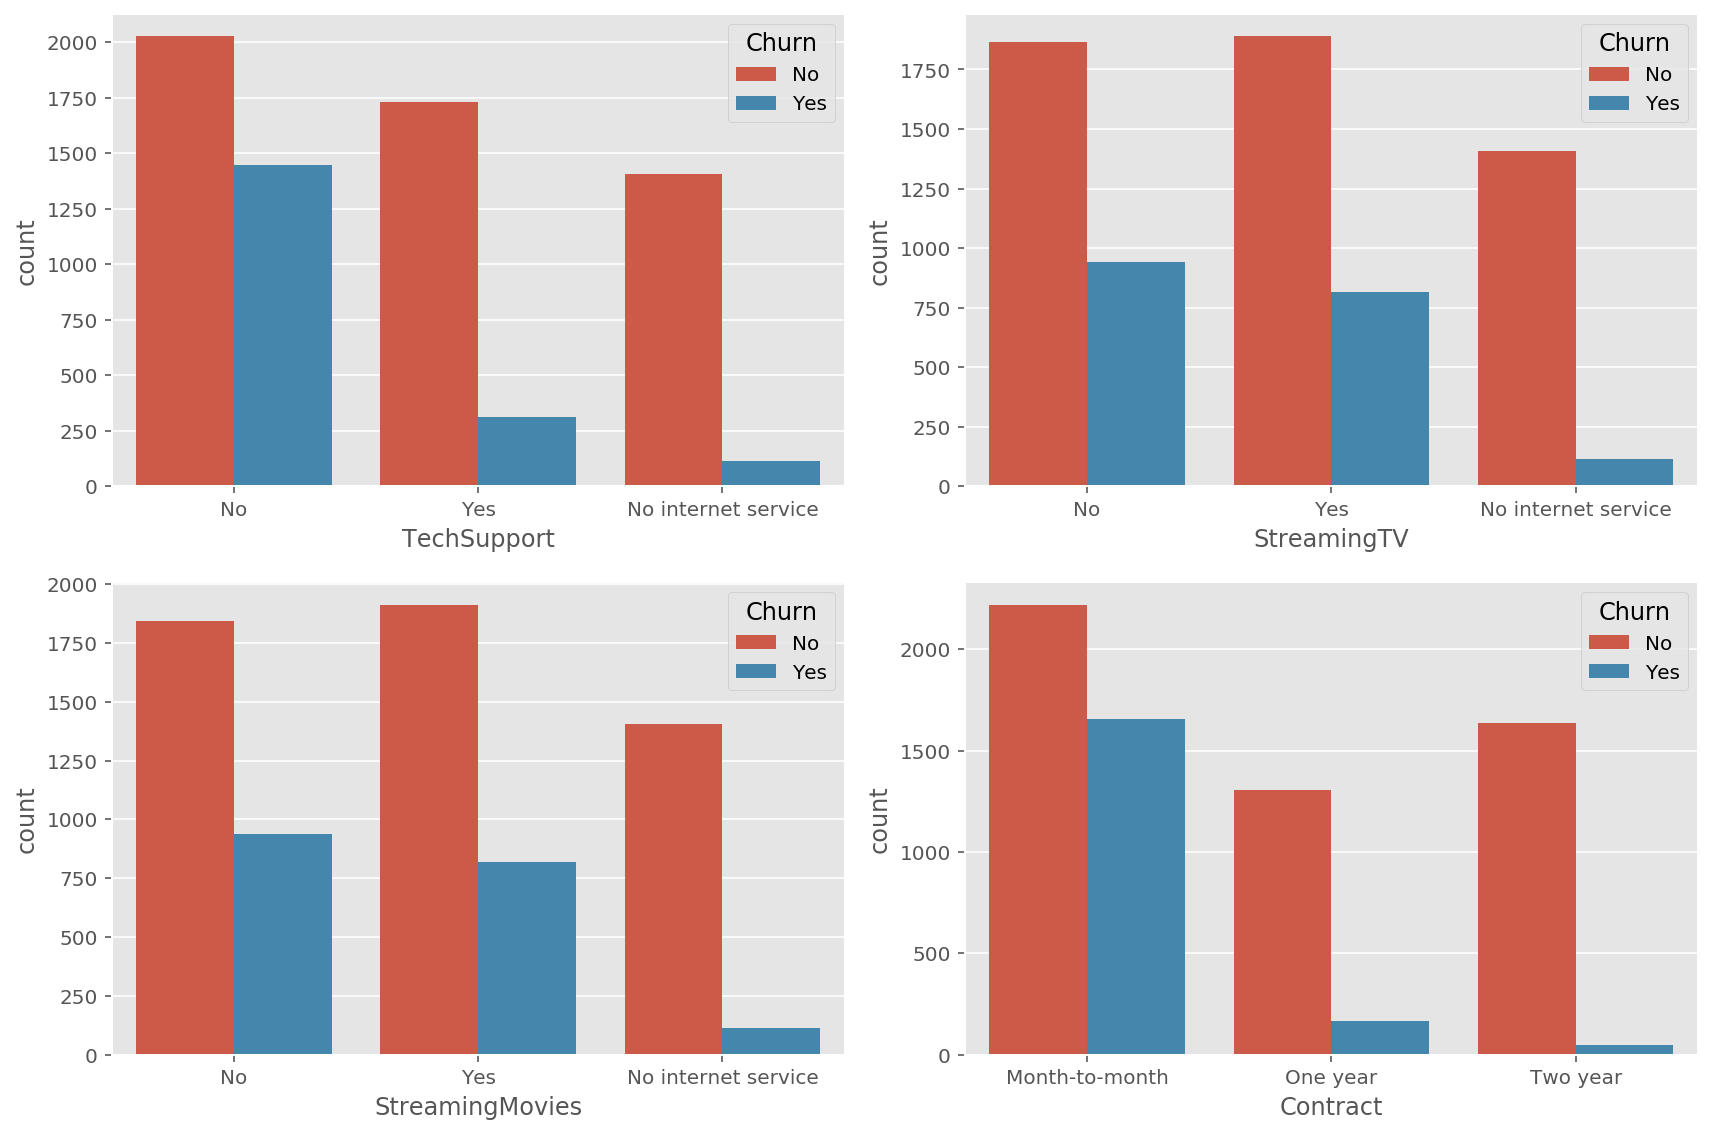

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for i in range(2):
    for j in range(2):
        _ = sns.countplot(data=data, x=obj[k], hue='Churn', ax=ax[i, j])
        k += 1

plt.tight_layout()

Similarly, let us briefly summarize plots above:

1) When there is no tech support - people churn (probably to where there is support!)

2) When no TV stream (or movie straming) is offered churning is more likely

3) Month-to-month contracts drive more churning!

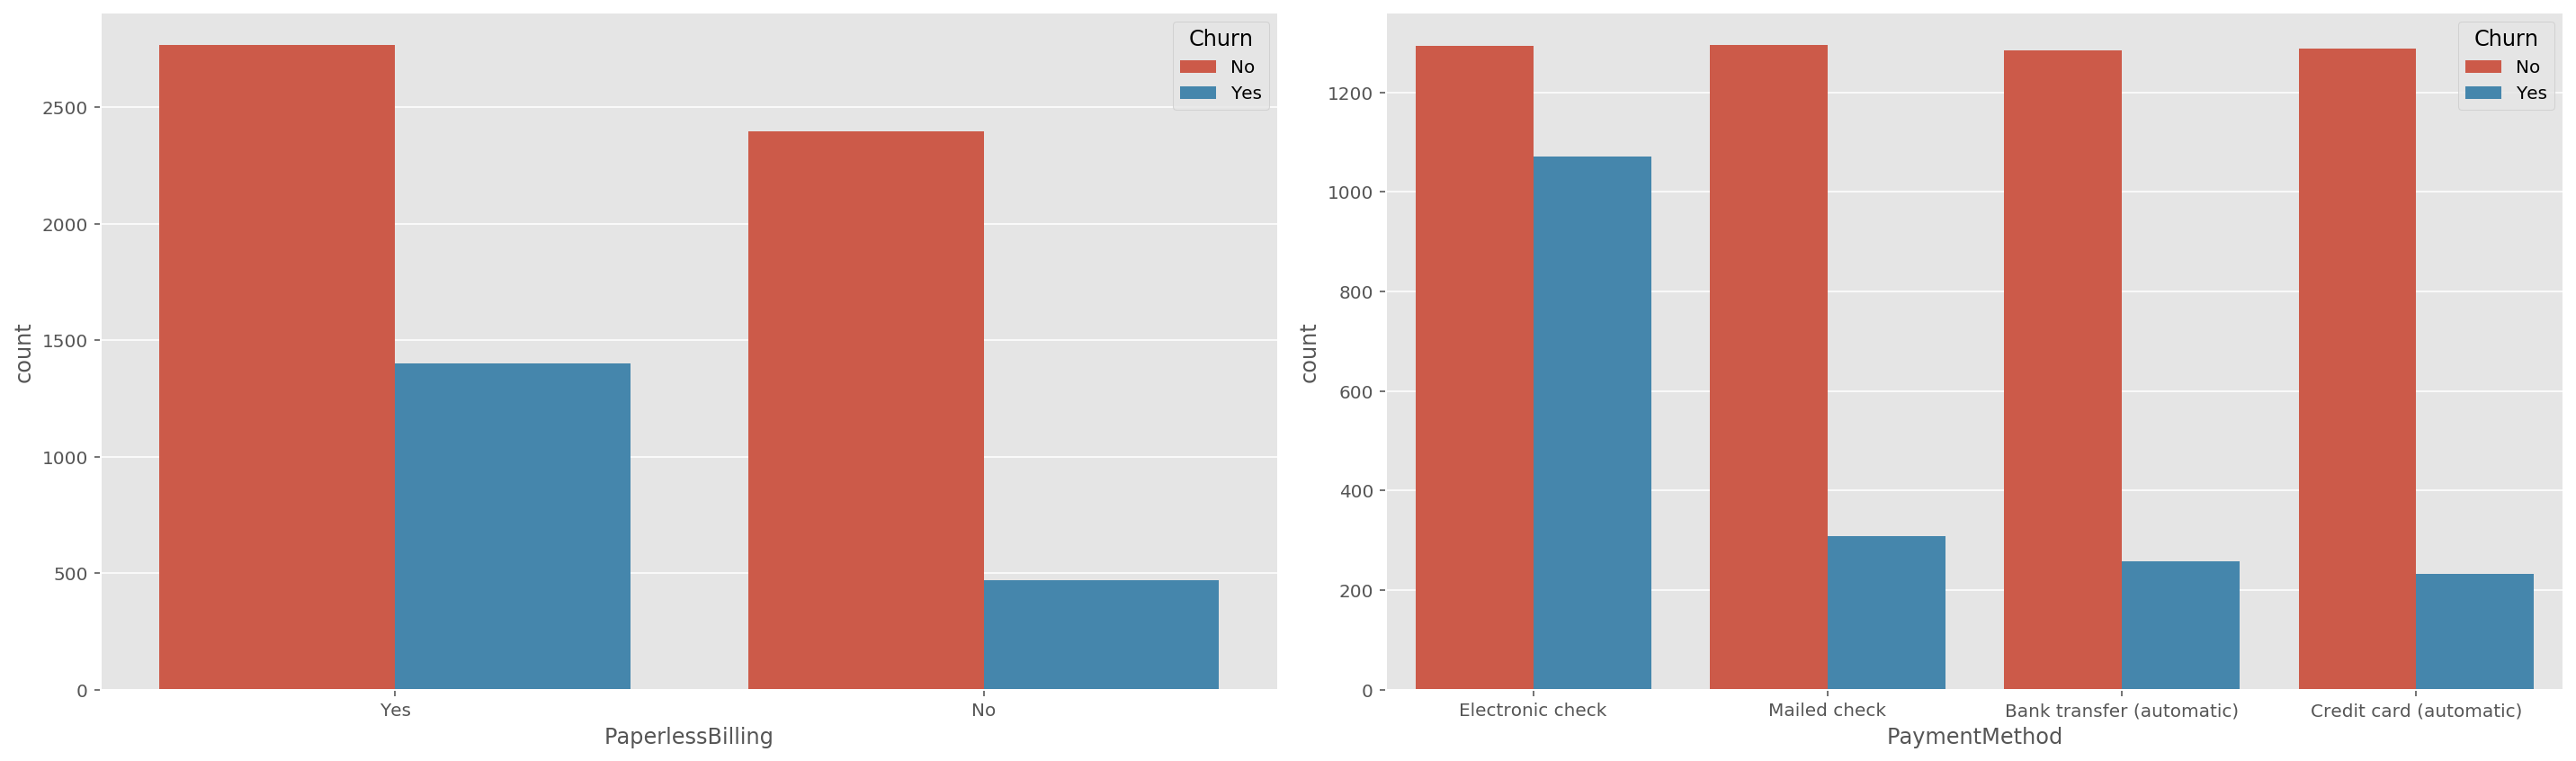

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
for i in range(2):
    _ = sns.countplot(data=data, x=obj[k], hue='Churn', ax=ax[i])
    k += 1

plt.tight_layout()

Electronic check users are churning way out of proportion compared to the rest of payment methods and users of paperless billing churn quite more as well

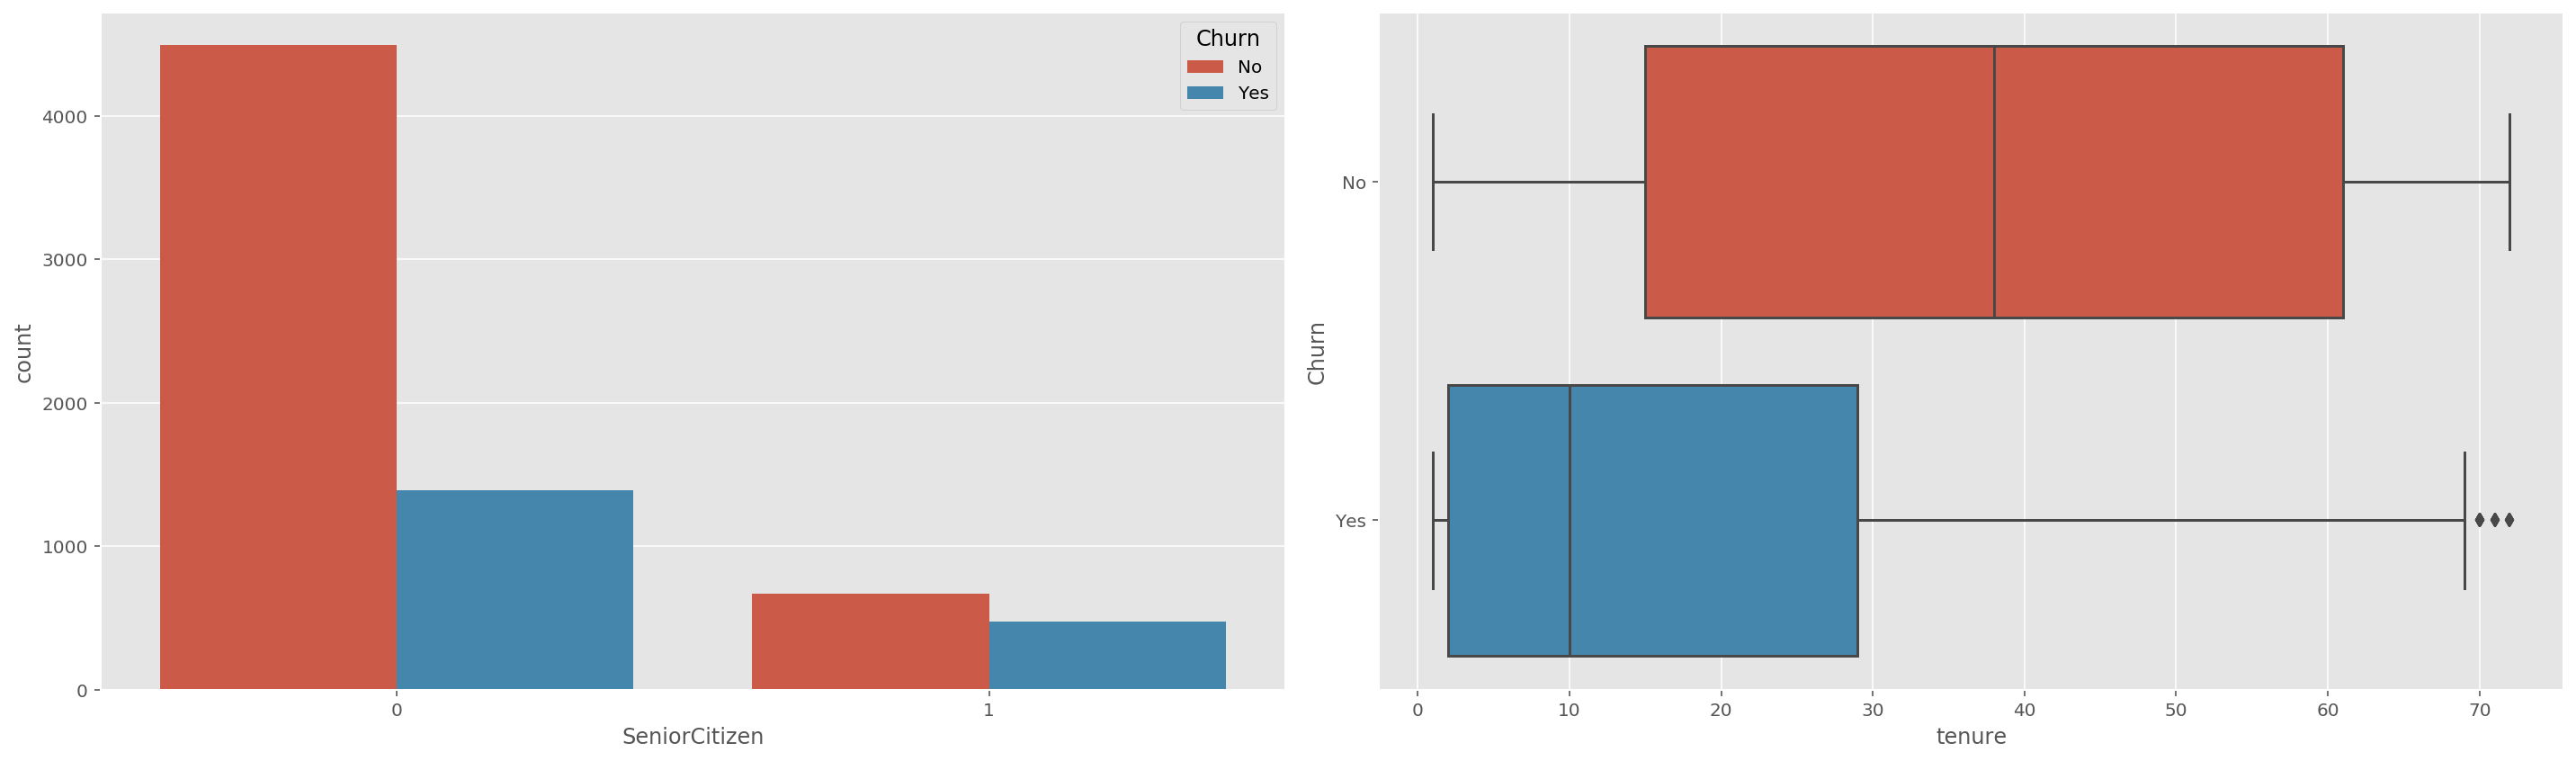

In [10]:
nums = data.select_dtypes(np.number).columns.tolist()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

_ = sns.countplot(data=data, x=nums[0], hue='Churn', ax=ax[0])
_ = sns.boxplot(data=data, y='Churn', x=nums[1])

plt.tight_layout()

If one is not a senior citizen then they are more likely to churn. I am unsure about the meaning of `tenure`, but those whose tenure is below 20 are more likely to churn.

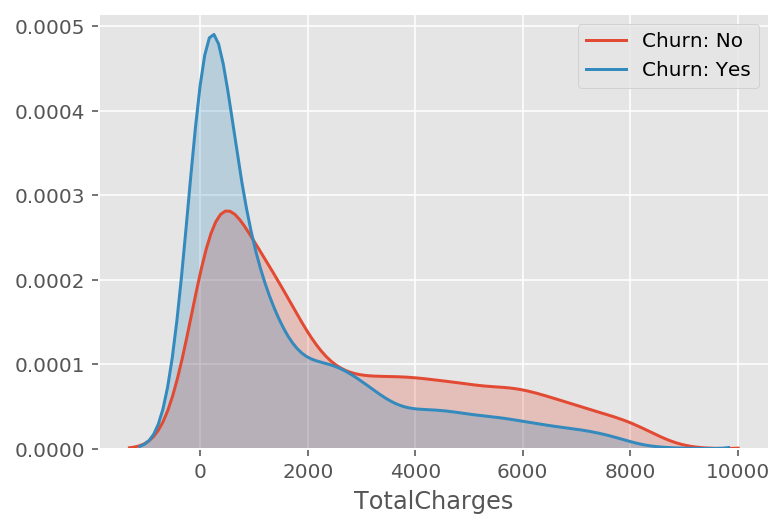

In [11]:
ax = sns.distplot(data[data['Churn'] == 'No'][nums[-1]],
                  label='Churn: No',
                  hist=False,
                  kde_kws={"shade": True})
_ = sns.distplot(data[data['Churn'] == 'Yes'][nums[-1]],
                 label='Churn: Yes',
                 hist=False,
                 kde_kws={"shade": True},
                 ax=ax)

_ = plt.legend()

Finally, if you charges are smaller, then you probably will not churn from the plot above.

Note that all of these statements are qualitative and more exact analysis would be needed using (probably) Bayesian statistics.

## Question 2
_Split data into training and test sets. Build a pipeline for dealing with categorical variables. Evaluate logistic regression, support vector machines, k-nearest neighbors, and decision trees using cross-validation. How different are the results? How does scaling the numerical features with StandardScaler influence the results?_

In [17]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             roc_auc_score, roc_curve, precision_score,
                             recall_score)

### No Standard scaling

In the experiments below we are not using standard scaling, only categorical label encoding (with `OrdinalEncoder` from sklearn) for the input features and a `LabelEncoder` applied to the target. 

We will use the ROC-AUC out-of-fold score to analyze performance of each model. All models (for now) will be run on default parameters, in Q3 we will include tuning. Other scores will be analyzed in Q5.

In [13]:
transformer = ColumnTransformer([('input_encoder', OrdinalEncoder(), obj)],
                                remainder='passthrough')
label_enc = LabelEncoder()
X = data.drop(['Churn'], axis=1)
target = label_enc.fit_transform(data['Churn'])

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    target,
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=2020)
skfold = StratifiedKFold(n_splits=5, shuffle=False)

In [15]:
def cross_validate(pipeline: Pipeline,
                   dataset=(x_train, y_train),
                   suppress_out=False):
    oof_roc_auc = {'train': [], 'val': []}
    for train_id, val_id in skfold.split(x_train, y_train):
        x_train_, y_train_ = x_train.iloc[train_id, :], y_train[train_id]
        x_val_, y_val_ = x_train.iloc[val_id, :], y_train[val_id]

        model = pipeline.fit(x_train_, y_train_)
        oof_roc_auc['train'].append(
            roc_auc_score(y_true=y_train_,
                          y_score=model.predict_proba(x_train_)[:, 1]))
        oof_roc_auc['val'].append(
            roc_auc_score(y_true=y_val_,
                          y_score=model.predict_proba(x_val_)[:, 1]))

    if not suppress_out:
        print(
            f"Mean train roc_auc score: {np.mean(oof_roc_auc['train']):.3f}," +
            f" std={np.std(oof_roc_auc['train']):.3f}")
        print(
            f"Mean validation roc_auc score: {np.mean(oof_roc_auc['val']):.3f},"
            + f" std={np.std(oof_roc_auc['val']):.3f}")
    return oof_roc_auc

#### Logistic Regression

In [18]:
pipeline_logreg = Pipeline([('input_encode', transformer),
                            ('logreg', LogisticRegression(max_iter=1000))])
oof_roc_auc_log_reg_no_std = cross_validate(pipeline_logreg)

Mean train roc_auc score: 0.848, std=0.004
Mean validation roc_auc score: 0.844, std=0.014


#### SVC

In [20]:
pipeline_svc = Pipeline([('input_encode', transformer),
                         ('svc', SVC(probability=True))])
oof_roc_auc_svc_no_std = cross_validate(pipeline_svc)

Mean train roc_auc score: 0.793, std=0.003
Mean validation roc_auc score: 0.793, std=0.019


#### k-NN

In [21]:
pipeline_knn = Pipeline([('input_encode', transformer),
                         ('knn', KNeighborsClassifier())])

oof_roc_auc_knn_no_std = cross_validate(pipeline_knn)

Mean train roc_auc score: 0.887, std=0.002
Mean validation roc_auc score: 0.740, std=0.011


#### Decision Tree

In [22]:
pipeline_tree = Pipeline([('input_encode', transformer),
                          ('tree', DecisionTreeClassifier())])
oof_roc_auc_tree_no_std = cross_validate(pipeline_tree)

Mean train roc_auc score: 1.000, std=0.000
Mean validation roc_auc score: 0.651, std=0.008


### With Standard Scaling

In [23]:
transformer = ColumnTransformer([('input_encoder', OrdinalEncoder(), obj)],
                                remainder='passthrough')

#### Logistic Regression

In [24]:
pipeline_logreg_std = Pipeline([('input_encode', transformer),
                                ('scaler', StandardScaler()),
                                ('logreg', LogisticRegression(max_iter=1000))])
oof_roc_auc_log_reg_std = cross_validate(pipeline_logreg)

Mean train roc_auc score: 0.848, std=0.003
Mean validation roc_auc score: 0.844, std=0.012


#### SVC

In [28]:
pipeline_svc_std = Pipeline([('input_encode', transformer),
                             ('scaler', StandardScaler()),
                             ('svc', SVC(probability=True))])
oof_roc_auc_svc_std = cross_validate(pipeline_svc_std)

Mean train roc_auc score: 0.872, std=0.003
Mean validation roc_auc score: 0.797, std=0.012


#### k-NN

In [30]:
pipeline_knn_std = Pipeline([('input_encode', transformer),
                             ('scaler', StandardScaler()),
                             ('knn', KNeighborsClassifier())])

oof_roc_auc_knn_std = cross_validate(pipeline_knn)

Mean train roc_auc score: 0.891, std=0.002
Mean validation roc_auc score: 0.761, std=0.012


#### Decision Tree

In [31]:
pipeline_tree_std = Pipeline([('input_encode', transformer),
                              ('scaler', StandardScaler()),
                              ('tree', DecisionTreeClassifier())])
oof_roc_auc_tree_std = cross_validate(pipeline_tree)

Mean train roc_auc score: 1.000, std=0.000
Mean validation roc_auc score: 0.653, std=0.007


### Conclusion

It is hard to judge the performance on the default parameters, but so far the best performing model is Logistic Regression followed by SVC. On default values we cannot see significant improvement given by scaling, but we will use it moving forward as a way to equalize benchmarking. The best model so far is Logistic regression.

|Model| Out-of-Fold AUC on validation, With Scaling |  Out-of-Fold AUC on validation, No Scaling |
|-----|------------------|------------------|
| Logistic Regression | 0.844  | 0.844  |
| Support Vector Machine| __0.797__|  0.793 |
| k Nearest Neighbors| __0.761__  | 0.740  |
|Decision Tree Classifier| __0.653__  |  0.651 |

## Question 3

_Tune the model parameters_ :

a.       _Visualize the performance of logistic regression as a function of the regularization parameter._

b.       _Visualize the performance of linear SVM as a function of the regularization parameter._

c.       _Visualize the performance of kNN as a function of k._

d.       _Use RandomSearchCV to tune the decision tree model with max_depth, max_leaf_nodes, min_samples_split, min_samples_leaf, and min_weight_fraction_leaf._

### Part A: performance of logistic regression as a function of the regularization parameter

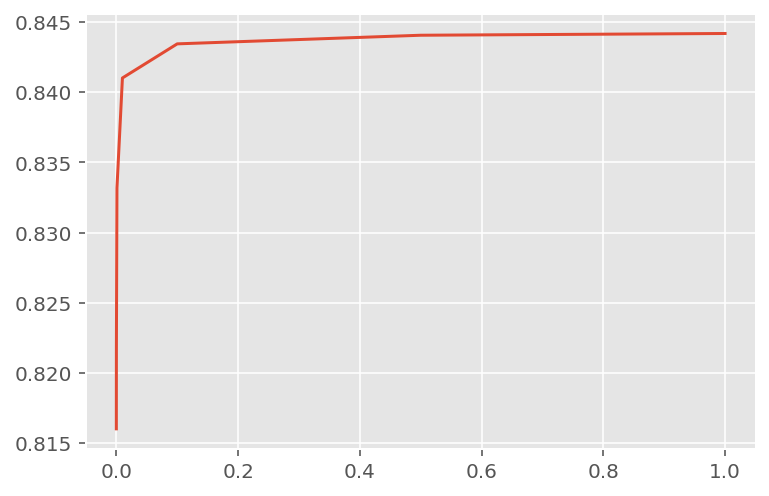

In [34]:
val_scores = []
Cs = [1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1.0]
for C in Cs:
    pipeline_logreg = Pipeline([('input_encode', transformer),
                                ('scaler', StandardScaler()),
                                ('logreg',
                                 LogisticRegression(C=C, max_iter=1000))])
    oof_roc_auc_log_reg = cross_validate(pipeline_logreg, suppress_out=True)
    val_scores.append(np.mean(oof_roc_auc_log_reg['val']))

_ = plt.plot(Cs, val_scores)

### Part B: Performance of linear SVM as a function of the regularization parameter

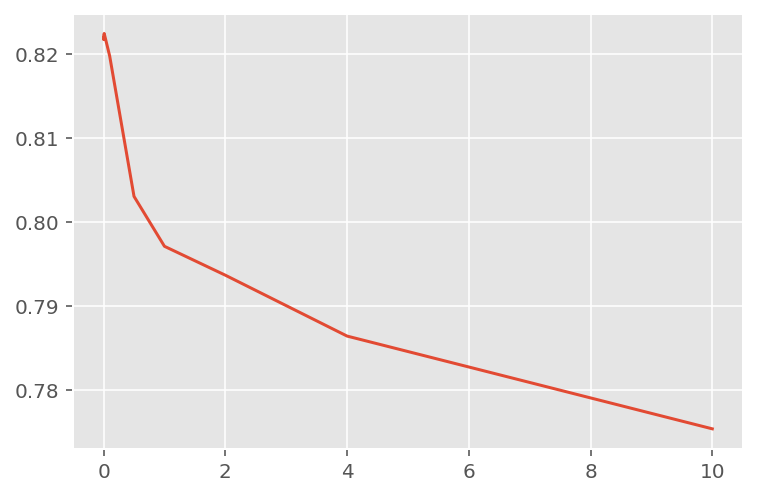

In [35]:
val_scores = []
Cs = [1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1.0, 2.0, 4.0, 10.0]
for C in Cs:
    pipeline_svc = Pipeline([('input_encode', transformer),
                             ('scaler', StandardScaler()),
                             ('svc', SVC(C=C, probability=True))])
    oof_roc_auc_svc = cross_validate(pipeline_svc, suppress_out=True)
    val_scores.append(np.mean(oof_roc_auc_svc['val']))

_ = plt.plot(Cs, val_scores)

### Part C: Performance of kNN as a function of k

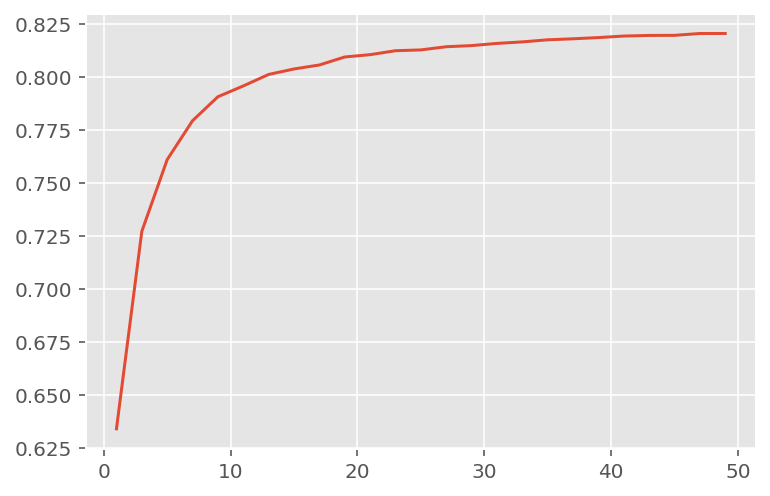

In [36]:
val_scores = []
ks = list(range(1, 51, 2))
for k in ks:
    pipeline_knn = Pipeline([('input_encode', transformer),
                             ('scaler', StandardScaler()),
                             ('knn', KNeighborsClassifier(k))])
    oof_roc_auc_knn = cross_validate(pipeline_knn, suppress_out=True)
    val_scores.append(np.mean(oof_roc_auc_knn['val']))

_ = plt.plot(ks, val_scores)

### Part D: RandomSearchCV

Use RandomSearchCV to tune the decision tree model with `max_depth`, `max_leaf_nodes`, `min_samples_split`, `min_samples_leaf`, and `min_weight_fraction_leaf`. Randomized quicksearch complained when the estimator was passed as a pipeline, hence we split

In [37]:
params = {
    'max_depth': randint(3, 20),
    'max_leaf_nodes': randint(3, 20),
    'min_samples_split': uniform(0, 1),
    'min_samples_leaf': uniform(0, 0.5),
    'min_weight_fraction_leaf': uniform(0, 0.5)
}

tree = DecisionTreeClassifier()  
cv = RandomizedSearchCV(tree,
                        params,
                        n_iter=200,
                        scoring=make_scorer(roc_auc_score),
                        cv=5,
                        random_state=42)

In [38]:
x_train_ = transformer.fit_transform(x_train)

cv.fit(x_train_, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [39]:
best_tree = cv.best_estimator_
results = pd.DataFrame.from_dict(cv.cv_results_)

In [40]:
pipeline_tree = Pipeline([('input_encode', transformer),
                          ('scaler', StandardScaler()),
                          ('tree', best_tree)])
oof_roc_auc_tree = cross_validate(pipeline_tree)

Mean train roc_auc score: 0.776, std=0.003
Mean validation roc_auc score: 0.770, std=0.011


## Q4: Is polynomial kernel and Gaussian RBF kernel helpful for improving the performance of the SVM model?

To answer the question, we will perform the cross validation grid search

In [41]:
#oof_roc_auc_svc = cross_validate(pipeline_svc, suppress_out=False)
params = dict(kernel=['rbf', 'poly'], degree=[1, 2, 3, 4, 5])
gridsearch = GridSearchCV(SVC(C=1, probability=True), params)

In [42]:
x_train_ = transformer.fit_transform(x_train)
x_train_ = StandardScaler().fit_transform(x_train_)
gridsearch.fit(x_train_, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'degree': [1, 2, 3, 4, 5], 'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

According to the `gridsearch` output below, `rbf` kernel works best here.

In [43]:
pipeline_svc = Pipeline([('input_encode', transformer),
                         ('scaler', StandardScaler()),
                         ('svc', gridsearch.best_estimator_.set_params(C=1e-10))
                         ])
oof_roc_auc_svc = cross_validate(pipeline_svc)

Mean train roc_auc score: 0.835, std=0.003
Mean validation roc_auc score: 0.832, std=0.012


## Question 5

_Choose the best model by analyzing the accuracy, precision, recall, ROC curve, and auc score_

We will perform the following analysis:

1) Train each model with best parameters from previous tasks on the `x_train` set

2) calculate each score on the test set

3) select the best

Let us determine what we care about more among possible prediction results. We definitely care about `true positives`, that is, the main candidates for churning, we want to keep these customers. What about `true negatives`? These customers won't churn, at least by prediction, therefore, we don't have to worry about them (hopefully).

More important are `false positives` and `false negatives`. False positives means we think that the customer is churning and turns out that they are not. Trying to keep a false positive we may loose a true positive.

`False negative` is a completely different scenario. These are people who might churn but the algorithm predicts the opposite. Even if the model is wrong, we don't want to risk of them churning, therefore we will emphasize importance `false negatives`. We can accept high `false negative` and low `false positive`, but not the other way around.

In [44]:
def visualize(model):
    model_logreg = model.fit(x_train, y_train)

    test_preds = model.predict(x_test)
    test_proba = model.predict_proba(x_test)[:, 1]

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
    fpr, tpr, thresholds = roc_curve(y_test, test_proba)
    acc = accuracy_score(y_true=y_test, y_pred=test_preds)
    prec = precision_score(y_true=y_test, y_pred=test_preds)
    rec = recall_score(y_true=y_test, y_pred=test_preds)
    roc_auc = roc_auc_score(y_true=y_test, y_score=test_proba)

    _ = sns.lineplot(x=fpr, y=tpr, label="ROC-AUC Curve", ax=ax[0])
    ax[0].fill_between(fpr, tpr, alpha=0.3)
    _ = sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_preds),
                    ax=ax[1],
                    annot=True, fmt="d")
    _ = plt.xlabel("Prediced Class")
    _ = plt.ylabel("True Class")
    _ = plt.title(
        f"Accuracy: {acc:.3}, Precision: {prec:.3}, Recall: {rec:.3}, ROC-AUC score: {roc_auc:.3}"
    )
    return fpr, tpr

In [45]:
pipeline_logreg = Pipeline([('input_encode', transformer),
                            ('scaler', StandardScaler()),
                            ('logreg', LogisticRegression(C=3, tol=1e-6, max_iter=5000))])

pipeline_svc = Pipeline([('input_encode', transformer),
                         ('scaler', StandardScaler()),
                         ('svc', SVC(C=10, kernel='rbf', probability=True))])

pipeline_tree = Pipeline([('input_encode', transformer),
                          ('scaler', StandardScaler()),
                          ('tree', best_tree)])

pipeline_knn = Pipeline([('input_encode', transformer),
                         ('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier(21))])

### Logistic Regression

This model has high accuracy, the highest ROC-AUC score and the highest Precision/Recall combination

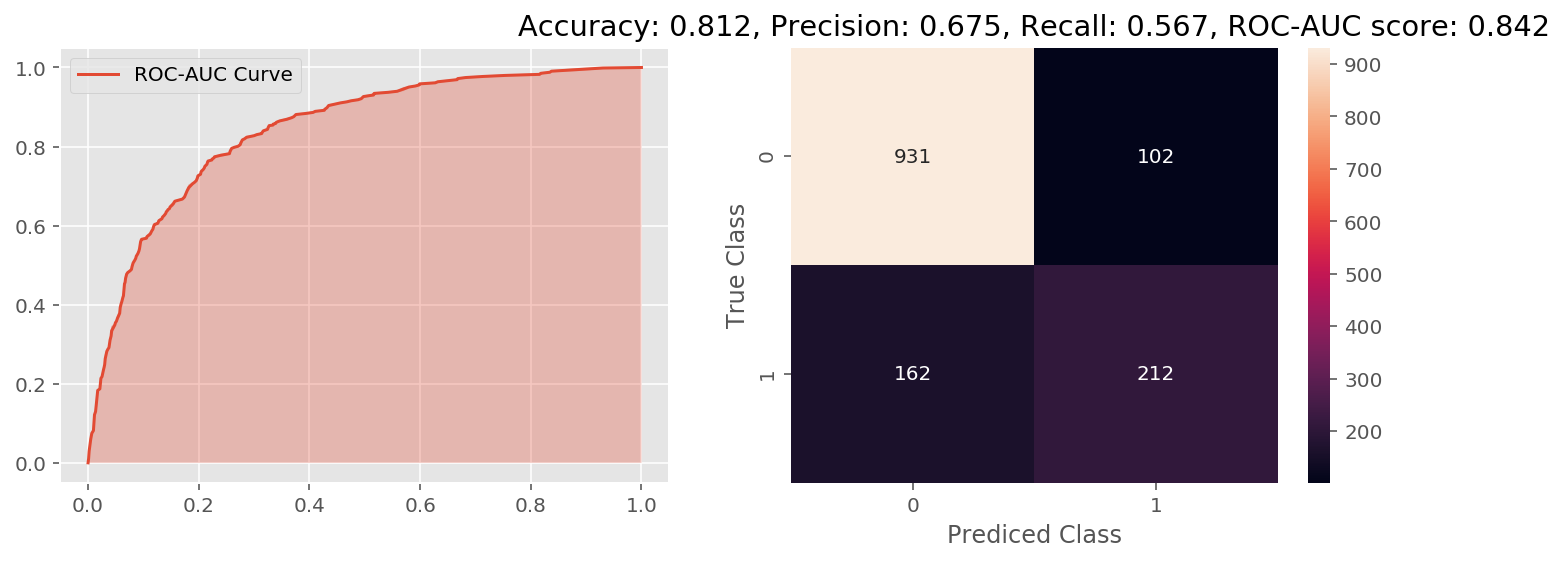

In [46]:
logreg_roc = visualize(pipeline_logreg)

### Support Vector Machine

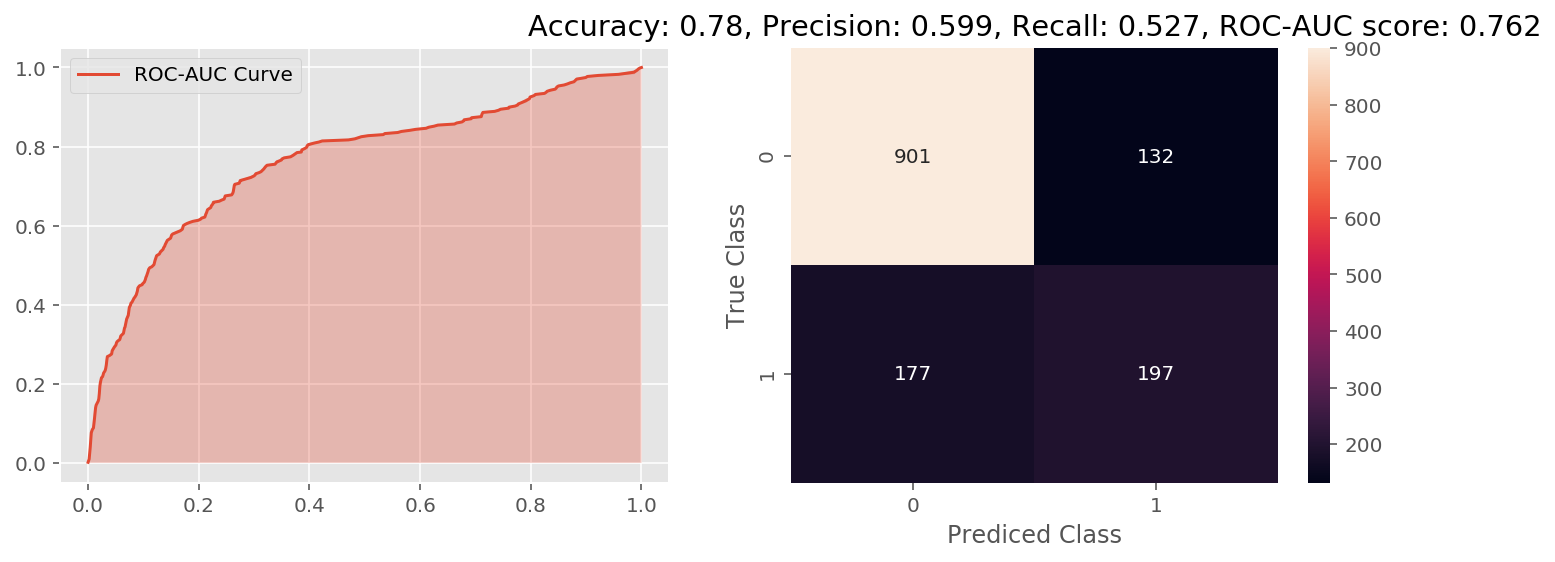

In [47]:
svm_roc = visualize(pipeline_svc)

### Decision Tree

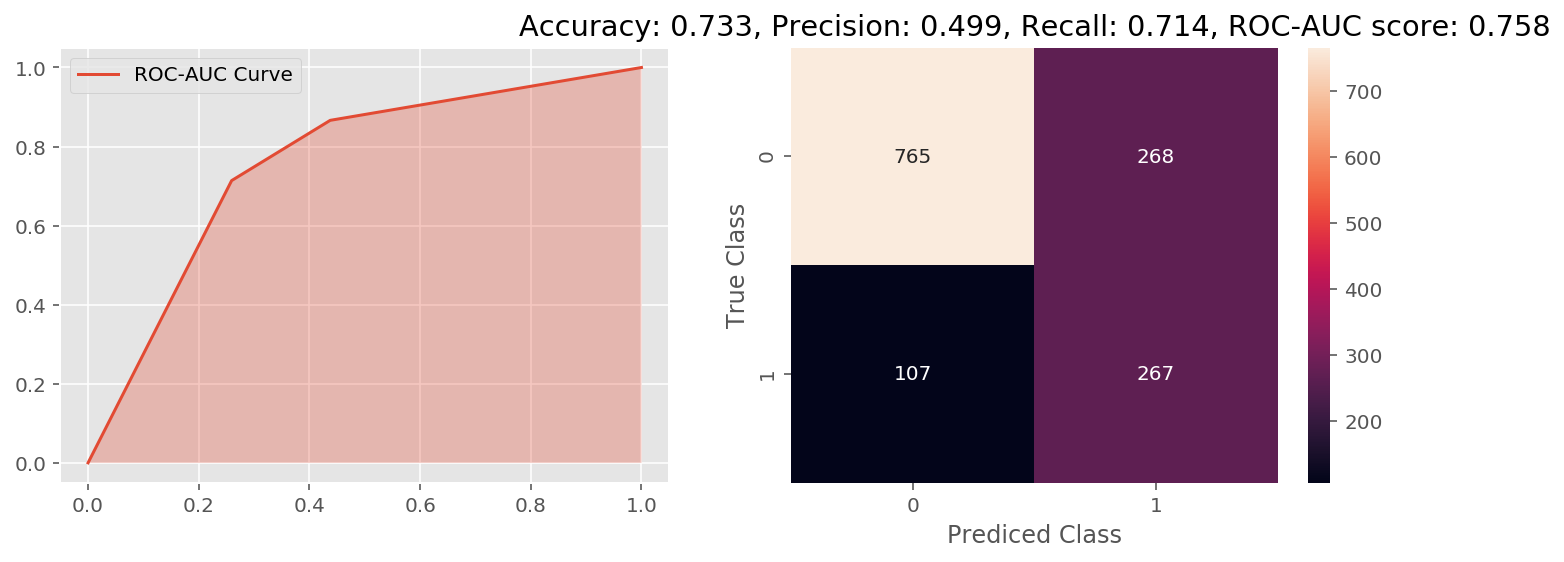

In [48]:
tree_roc = visualize(pipeline_tree)

### k-NN

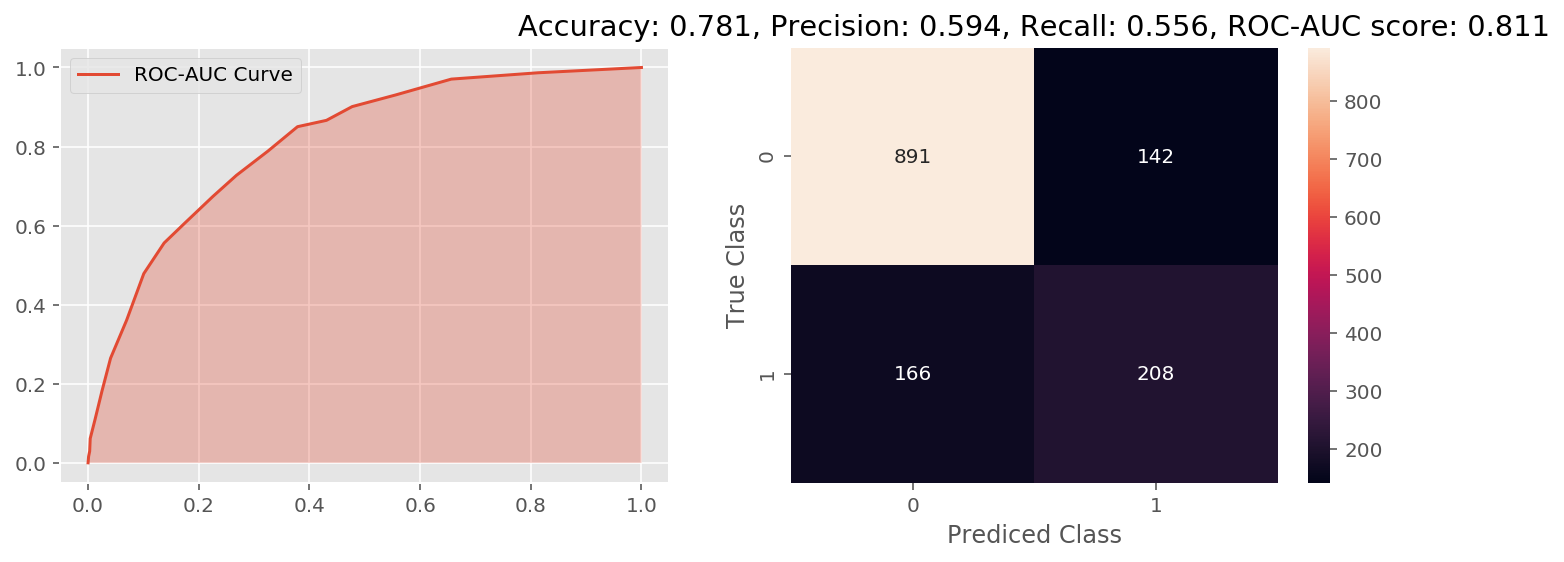

In [49]:
knn_roc = visualize(pipeline_knn)

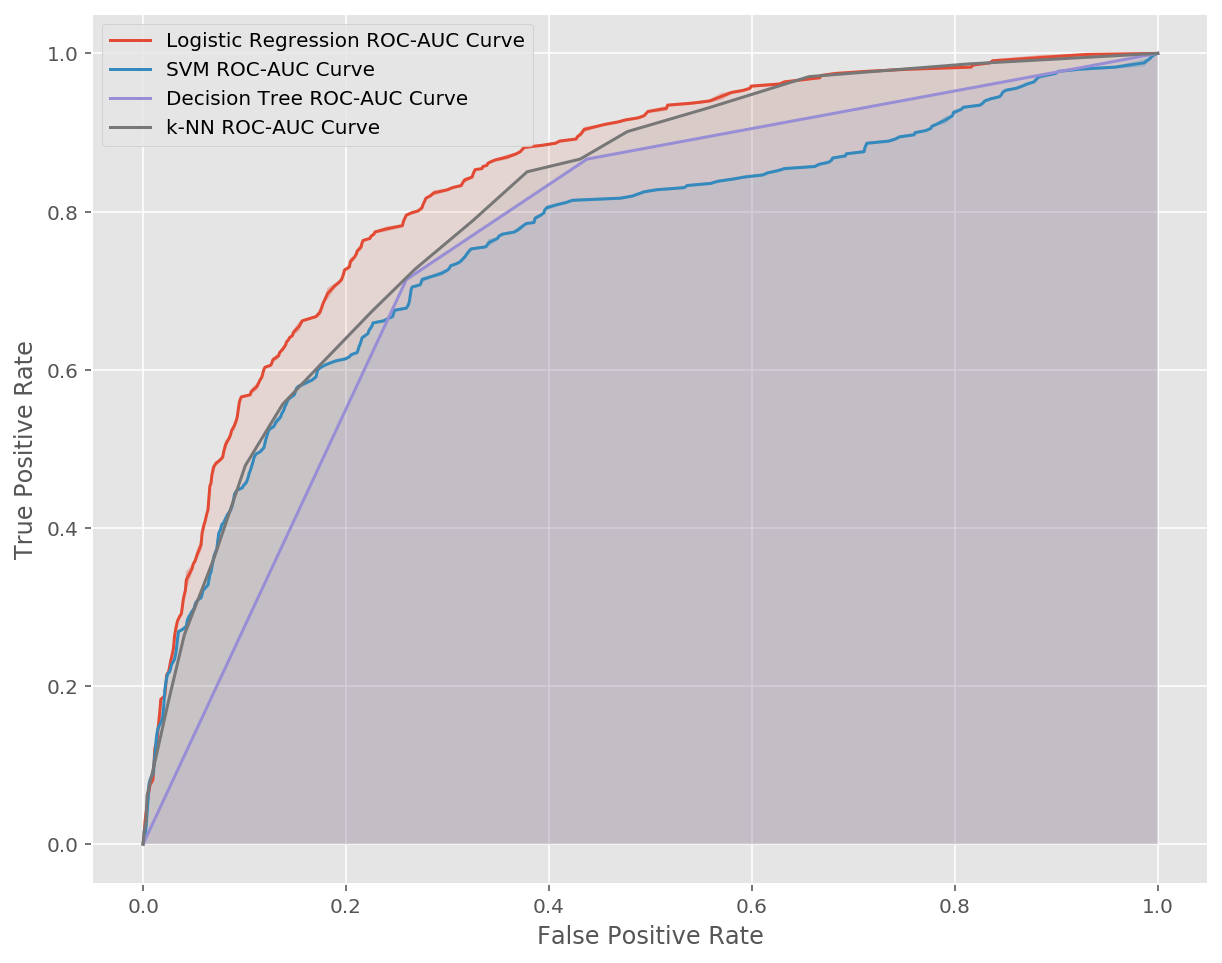

In [50]:
plt.figure(figsize=(10, 8))
ax = sns.lineplot(x=logreg_roc[0],
                  y=logreg_roc[1],
                  label="Logistic Regression ROC-AUC Curve")
_ = plt.fill_between(logreg_roc[0], logreg_roc[1], alpha=0.1)

_ = sns.lineplot(x=svm_roc[0], y=svm_roc[1], label="SVM ROC-AUC Curve", ax=ax)
_ = plt.fill_between(svm_roc[0], svm_roc[1], alpha=0.1)

_ = sns.lineplot(x=tree_roc[0],
                 y=tree_roc[1],
                 label="Decision Tree ROC-AUC Curve",
                 ax=ax)
_ = plt.fill_between(tree_roc[0], tree_roc[1], alpha=0.1)

_ = sns.lineplot(x=knn_roc[0], y=knn_roc[1], label="k-NN ROC-AUC Curve", ax=ax)

_ = plt.fill_between(knn_roc[0], knn_roc[1], alpha=0.1)

_ = plt.xlabel("False Positive Rate")
_ = plt.ylabel("True Positive Rate")

According to the ROC-AUC, logistic regression is the best at separating true positives and true negatives. Decision tree has the highest recall, that is ratio of true positives to all actual positives (TP + FN).

## Question 5

_Which types of customers are less likely to end the service?_

In [51]:
logreg = pipeline_logreg.named_steps['logreg']

In [53]:
logreg.coef_

array([[-0.02266049, -0.01681739, -0.0262998 , -0.29150206,  0.06470627,
         0.17804443, -0.24632964, -0.13103882, -0.10445852, -0.236103  ,
         0.01186088,  0.01818746, -0.61139221,  0.17174108,  0.03823714,
         0.08003877, -1.43314832,  0.67430168,  0.68624217]])

In [65]:
coefs = {
    k: v
    for k, v in sorted(dict(
        (x, y) for (x, y) in zip(data.columns, logreg.coef_[0])).items(),
                       reverse=True,
                       key=lambda item: abs(item[1]))
}

In [66]:
coefs

{'PaymentMethod': -1.4331483168476935,
 'TotalCharges': 0.6862421746531473,
 'MonthlyCharges': 0.6743016821797259,
 'StreamingTV': -0.6113922114767534,
 'Dependents': -0.2915020640475503,
 'MultipleLines': -0.2463296438057424,
 'OnlineBackup': -0.2361029971083726,
 'PhoneService': 0.17804442615345945,
 'StreamingMovies': 0.17174108195136975,
 'InternetService': -0.1310388200019162,
 'OnlineSecurity': -0.10445851540440672,
 'PaperlessBilling': 0.08003877320791383,
 'tenure': 0.06470626902213283,
 'Contract': 0.03823714355579293,
 'Partner': -0.02629979659378079,
 'gender': -0.022660494509420613,
 'TechSupport': 0.01818746260140195,
 'SeniorCitizen': -0.016817394012524595,
 'DeviceProtection': 0.011860884720041247}

We observe from the coefficients of the SVM that the top-5 largest coefficients are Payment Method, Total Charges, Monthly Charges, Streaming TV and Dependents.

In [99]:
transformed_data = pd.DataFrame(np.append(x_train_, y_train.reshape((-1,1)), 1), columns=data.columns)

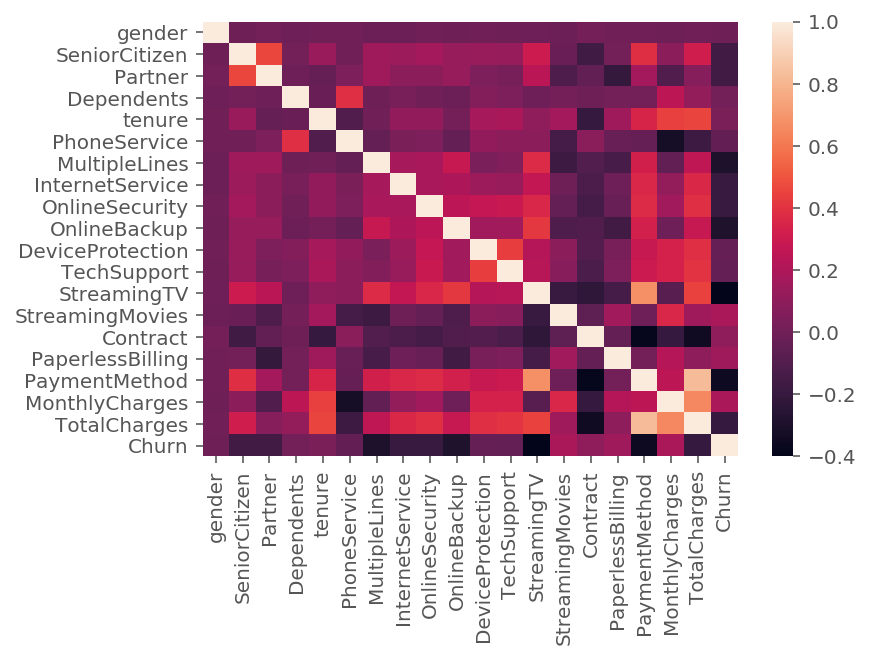

In [105]:
sns.heatmap(transformed_data.corr(), )